# Problem Set 2
1. **Call center data set – exponential likelihood with a gamma prior.** *Estimate the number of calls per minute for the 13th hour of the call center data set.*
*Results to compute:*
- *Posterior 98% confidence interval over λ (check that it matches results in the solution notebook below)*
- *Histogram of posterior λ samples*

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt
import pystan

%matplotlib inline

In [2]:
# load data set
waiting_times_day = np.loadtxt(
    'https://course-resources.minerva.kgi.edu/uploaded_files/mke/'
    '00124343-8397/call-center.csv')

# create 24 empty lists (one per hour)
waiting_times_per_hour = [[] for _ in range(24)]

# split the data into 24 series (one per hour)
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

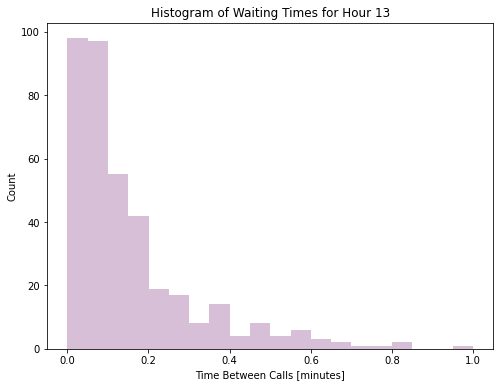

In [19]:
# plot histogram of waiting times for hour 13
hour_index = 13
waiting_times_hour = waiting_times_per_hour[hour_index]

plt.figure(figsize=(8, 6))
plt.hist(waiting_times_hour, bins=20, color='thistle')
plt.xlabel('Time Between Calls [minutes]')
plt.ylabel('Count')
plt.title(f'Histogram of Waiting Times for Hour {hour_index}')
plt.show()

In [4]:
# define data for stan
call_data = {
    'alpha': 1,  # alpha = 1 resembles exponential distribution
    'beta': 0.25,
    'num_calls': len(waiting_times_hour),
    'waiting_times': waiting_times_hour,
}

In [5]:
# define stan model for posterior results
stan_code_1 = """

data {
    int<lower=1> num_calls;  // number of calls for hour 13
    real<lower=0> waiting_times[num_calls];  // waiting time per call
    real<lower=0> alpha;  // fixed prior hyperparameter
    real<lower=0> beta;   // fixed prior hyperparameter
}

parameters {
    real<lower=0> lambda_;  // waiting time parameter
}

model {
    lambda_ ~ gamma(alpha, beta);  // prior over lambda
    for (i in 1:num_calls) {
      waiting_times[i] ~ exponential(lambda_); // likelihood
    }
}

"""

stan_model_1 = pystan.StanModel(model_code=stan_code_1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4f497feae2bd6c34fc94ae92a6e50296 NOW.


In [6]:
# print posterior results
results_1 = stan_model_1.sampling(data=call_data)
print(results_1.stansummary(pars = ['lambda_'], probs = [0.01, 0.99]))

Inference for Stan model: anon_model_4f497feae2bd6c34fc94ae92a6e50296.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd     1%    99%  n_eff   Rhat
lambda_   6.35  8.2e-3   0.32   5.61    7.1   1485    1.0

Samples were drawn using NUTS at Mon Oct 18 11:52:20 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [7]:
# print 98% confidence interval
posterior_samples = results_1.extract()
conf_int = np.quantile(posterior_samples['lambda_'], [0.01, 0.99])
print(f'98% Confidence Interval: [{np.round(conf_int[0],2)}, \
{np.round(conf_int[1],2)}]')

98% Confidence Interval: [5.61, 7.1]


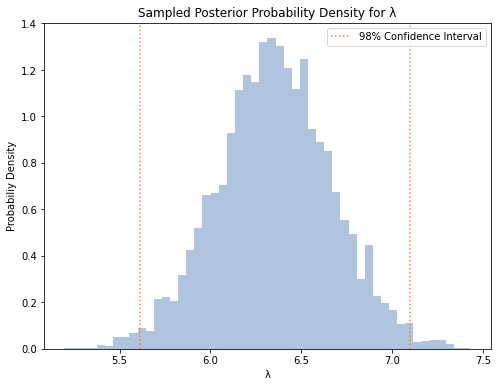

In [22]:
# plot histogram of results
plt.figure(figsize=(8, 6))
plt.hist(posterior_samples['lambda_'], bins=50, density=True, color='lightsteelblue')
plt.title('Sampled Posterior Probability Density for λ')
plt.xlabel('λ')
plt.ylabel('Probabiliy Density')
plt.axvline(
    conf_int[0], color='coral', linestyle=':',
    label='98% Confidence Interval')
plt.axvline(
    conf_int[1], color='coral', linestyle=':')
plt.legend()
plt.show()

2. **Normal likelihood with normal-inverse-gamma prior**
*Results to compute:*
- *95% posterior confidence intervals for the mean $\mu$ and variance $\sigma^2$ of the data.*
- *Take 10 samples from your posterior over $\mu$ and $\sigma^2$ and plot the normal distributions corresponding to them. See Task 3 in the solutions below – you should produce a plot similar to the one you find there.*

In [49]:
# import sample data
sample_data = np.array([3.54551763569501, 4.23799861761927, 4.72138425951628, -0.692265320368236, 3.04473513808788, 3.10721270732507, 3.42982225852764, 3.12153903971176, 3.60532628639808, 2.46561737557325, 1.64059465916131, 2.4621623937158, 2.76744495617481, 2.11580054750407, 5.14077208608354, 4.90288499104252, 1.43357579078348, 4.78997817363558, 1.93633438207439, 2.43698838097178, 3.95389148701877, 2.4242295507716, 2.90256268679023, 2.90931728045901, 0.658072819386888, 3.05946763895983, 3.42615331539605, 2.68842833004417, 2.35850130765166, 2.20014998540933, 4.73846511350084, 4.19839721414451, 2.11805510171691, -0.572742936038015, 0.389413982010623, 3.87846130744249, 1.34057656890858, 0.7235748351719, 5.11042369840174, 4.00747556696571, 3.18080956726965, 3.24677964069676, 5.1154659863626, 1.80276616697155, 0.305877679021404, -0.449168307882718, 4.63705561194774, 1.37783714058301, 4.9608149859515, 6.7764195802069, 1.75515522922399, 7.04457337435215, 0.625185284955128, 2.25130734369064, 2.19770178119255, 2.16858257249432, 6.25367644481438, 0.116081323476489, 2.06315857864341, 1.82409781471718, 5.15226741230987, 2.03408231293173, -1.12450854337596, 5.03511270642234, 2.03841989653263, 5.80911741751597, 2.31718128783245, 4.97575010580997, 3.34262752222776, -0.786983904253601, 0.777362359850013, 0.975825009321195, 3.76354577515958, 7.27215002907876, 1.35404089480189, 3.76567940257157, 3.48573993343334, 1.85976988586156, 1.93567061960716, 5.31071812003942, 2.96832987672751, 3.32378908637275, 2.61631960054551, 5.80897964052825, 4.95215217171488, 1.32036772796131, 3.79932542233371, 3.08108492766309, 2.6734110081666, -0.14251851138521, 2.48744375588965, 3.98463042123415, 6.32781680028, 4.0029172024315, 4.23210369459457, 1.71412938967325, 5.16492114963802, 2.53409673107906, 4.77346963973334, 3.34088878725551, 4.77681472750664, 3.81135755590976, 1.14054269983137, 1.42057452397702, 0.132142311125433, 7.12577254064672, 4.85422012781764, 4.15745720676399, 4.48763147363348, 1.56060322283629, 2.64821761542887, 1.26655351354548, 4.48497722937931, 4.3286302403783, 4.26157679512625, 4.0597558651364, 5.14051109132496, 2.5660348362221, 1.10764013818617, 0.386889523012303, 3.54150473246237, 3.57480214382351, 1.95150869584847, 2.70688970563118, 2.47971849820016, 6.50838037000679, 4.01511556826974, 1.11562740835344, 5.02637639472439, 4.38184491686864, 5.60423144047386, 2.40067408379298, 5.7849941378344, 2.37225791084559, 6.86031465910273, 4.09214858239736, 6.85994063692621, 3.62202415158781, -1.11220646958158, 3.73920971696866, 3.24533871512216, 1.28724203643002, 0.291152541773164, 0.368630935755111, 6.71607270510525, 5.42278455200833, 5.35188416119281, 2.305874586163, -1.85878097203032, 2.69877382351447, 4.84121860550417, 4.40973060799391, 5.04399320650774, 2.68632252661298, 6.06531610659912, 3.11881325011993, 3.45532087005125, 3.08442259840346, 4.43564424136733, 2.84252623135804, 1.50536798885106, 1.48868622407603, 2.07322837615663, 2.5476910210998, 5.66941808257884, 2.16731067416426, 2.49843958833905, 3.94586413879977, 0.316433764679541, -0.608937441815983, 2.5943436558557, 1.05516869528337, 2.1447601332725, 6.65846634141906, 2.1771555267834, 5.23953812029442, 3.53629759842647, 6.03263538017003, 3.85739159396599, 5.95093453004638, 1.12856987160476, 3.5559912886093, 2.21974864244489, 3.38471394882135, -1.90805399279409, 3.5113699258973, 4.49319955412346, 5.10507952638867, 1.08277895384184, 4.58403638422759, 1.37304994426824, 4.17566975753523, 3.36454182510378, 0.177136582644021, 2.91337423388405, 3.22796455457526, 2.80124198378441, 1.95189718582788, 3.37659263896246, -1.6463045238231])
print(len(sample_data), "data")

200 data


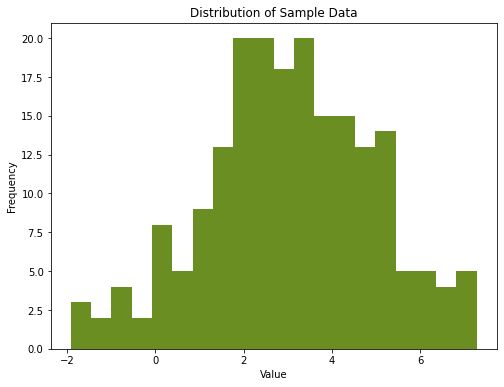

Data Sample Mean: 3.07
Data Sample Variance: 3.62


In [51]:
# plot histogram to check for normal distributed
plt.figure(figsize=(8, 6))
plt.hist(sample_data, bins=20, color='olivedrab')
plt.title('Distribution of Sample Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# calculate sample mean and variance
print('Data Sample Mean:', np.round(np.mean(sample_data),2))
print('Data Sample Variance:', np.round(np.var(sample_data),2))

In [52]:
# define data for stan
data_2 = {
    'mu' : 0,      # prior mean
    'nu' : 0.054,  # small since mean is uncertain
    'alpha': 1.12, # govern marginal prior over variance
    'beta': 0.4,
    'sample_data': sample_data,
    'num_sample_data': len(sample_data),
}

In [56]:
# define stan model for posterior results
stan_code_2 = """

data {
    int<lower=1> num_sample_data;  // number of data
    real sample_data[num_sample_data];  // data values (+ or -)
    real<lower=0> mu;  
    real<lower=0> nu;
    real<lower=0> alpha;  
    real<lower=0> beta;   
}

parameters {
    real<lower=0> x;  // x-values
    real<lower=0> sigma_2;  // standard deviation
}

model {
    x ~ normal(mu, sqrt(sigma_2/nu));  // prior
    sigma_2 ~ inv_gamma(alpha, beta);    
    
    for (i in 1:num_sample_data) {
      sample_data[i] ~ normal(x, sqrt(sigma_2)); // likelihood
    }
}

"""

stan_model_2 = pystan.StanModel(model_code=stan_code_2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_32ce4e8b222ff1a24c9fd4e3c7f65db5 NOW.


In [57]:
# print posterior results
results_2 = stan_model_2.sampling(data=data_2)
print(results_2.stansummary(pars = ['x', 'sigma_2'], probs = [0.025, 0.975]))

Inference for Stan model: anon_model_32ce4e8b222ff1a24c9fd4e3c7f65db5.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
x         3.07  2.6e-3   0.13   2.81   3.33   2570    1.0
sigma_2   3.62  6.5e-3   0.37   2.98   4.42   3204    1.0

Samples were drawn using NUTS at Mon Oct 18 13:31:17 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [58]:
# print 95% confidence interval
posterior_samples_2 = results_2.extract()
conf_int_x = np.quantile(posterior_samples_2['x'], [0.025, 0.975])
conf_int_sig = np.quantile(posterior_samples_2['sigma_2'], [0.025, 0.975])
print(f'95% Confidence Interval for x: [{np.round(conf_int_x[0],2)}, \
{np.round(conf_int_x[1],2)}]')
print(f'95% Confidence Interval for σ²: [{np.round(conf_int_sig[0],2)}, \
{np.round(conf_int_sig[1],2)}]')

95% Confidence Interval for x: [2.82, 3.33]
95% Confidence Interval for σ²: [2.98, 4.42]


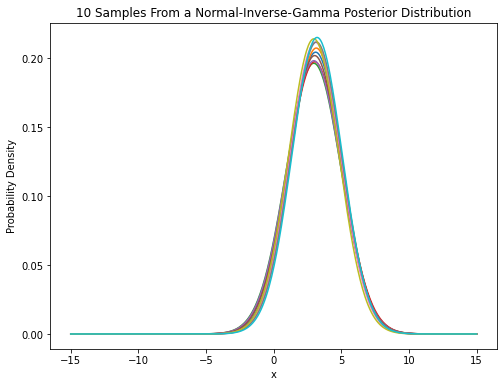

In [75]:
# generate 10 samples from the posterior
num_samples = 10
samples = []
for i in range(num_samples):
  x = np.random.choice(posterior_samples_2['x'])
  sigma_2 = np.random.choice(posterior_samples_2['sigma_2'])
  samples.append((x, sigma_2))

# plot normal distributions corresponding to the samples
plt.figure(figsize=(8, 6))
plot_x = np.linspace(-15, 15, 500)
for i in range(num_samples):
    plot_y = sts.norm.pdf(plot_x, loc=samples[i][0], 
                          scale=np.sqrt(samples[i][1]))
    plt.plot(plot_x, plot_y)
plt.title(f'{num_samples} Samples From a Normal-Inverse-Gamma Posterior Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.show()

3. **Log-normal HRTEM data. Normal likelihood log-transformed data and using a normal-inverse-gamma prior.**
*Results to compute:*
- *95% posterior confidence intervals for the $\mu$ and variance $\sigma^2$ of the log-transformed data. (Should match results under Task 3 of the solutions.)*
- *Take 10 samples from your posterior over $\mu$ and $\sigma^2$ and plot the log-normal distributions corresponding to them. See Task 5 in the solutions below – you should produce a plot similar to the one you find there, but with 10 pdfs rather than one.*

In [81]:
# import sample data
data_set = np.loadtxt('https://course-resources.minerva.kgi.edu/uploaded_files/mke/00075398-1635/hrtem.csv')
print('%i data, min: %f, max: %f' % (len(data_set), min(data_set), max(data_set)))

500 data, min: 1.051827, max: 28.942578


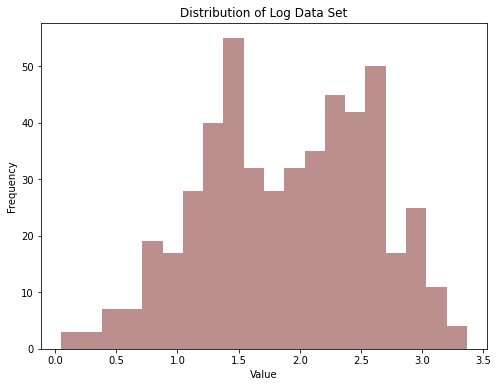

In [85]:
# transform data using log function
log_data_set = np.log(data_set)

# plot histogram
plt.figure(figsize=(8, 6))
plt.hist(log_data_set, bins=20, color='rosybrown')
plt.title('Distribution of Log Data Set')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [86]:
# define data for stan
data_3 = {
    'mu' : 2.3,      # prior mean
    'nu' : 11,  
    'alpha': 9.56, # govern marginal prior over variance
    'beta': 23.55,
    'log_data': log_data_set,
    'num_log_data': len(log_data_set),
}

In [87]:
# define stan model for posterior results
stan_code_3 = """

data {
    int<lower=1> num_log_data;  // number of data
    real log_data[num_log_data];  // log data values
    real<lower=0> mu;  
    real<lower=0> nu;
    real<lower=0> alpha;  
    real<lower=0> beta;   
}

parameters {
    real<lower=0> x;  // x-values
    real<lower=0> sigma_2;  // standard deviation
}

model {
    x ~ normal(mu, sqrt(sigma_2/nu));  // prior
    sigma_2 ~ inv_gamma(alpha, beta);    
    
    for (i in 1:num_log_data) {
      log_data[i] ~ normal(x, sqrt(sigma_2)); // likelihood
    }
}

"""

stan_model_3 = pystan.StanModel(model_code=stan_code_3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_83cb0ef83f650cb3d2aad307b09857a3 NOW.


In [88]:
# print posterior results
results_3 = stan_model_3.sampling(data=data_3)
print(results_3.stansummary(pars = ['x', 'sigma_2'], probs = [0.025, 0.975]))

Inference for Stan model: anon_model_83cb0ef83f650cb3d2aad307b09857a3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
x          1.9  6.0e-4   0.03   1.84   1.97   3079    1.0
sigma_2   0.56  5.4e-4   0.03   0.49   0.63   4232    1.0

Samples were drawn using NUTS at Mon Oct 18 14:26:34 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [89]:
# print 95% confidence interval
posterior_samples_3 = results_3.extract()
conf_int_x_3 = np.quantile(posterior_samples_3['x'], [0.025, 0.975])
conf_int_sig_3 = np.quantile(posterior_samples_3['sigma_2'], [0.025, 0.975])
print(f'95% Confidence Interval for x: [{np.round(conf_int_x_3[0],2)}, \
{np.round(conf_int_x_3[1],2)}]')
print(f'95% Confidence Interval for σ²: [{np.round(conf_int_sig_3[0],2)}, \
{np.round(conf_int_sig_3[1],2)}]')

95% Confidence Interval for x: [1.84, 1.97]
95% Confidence Interval for σ²: [0.49, 0.63]


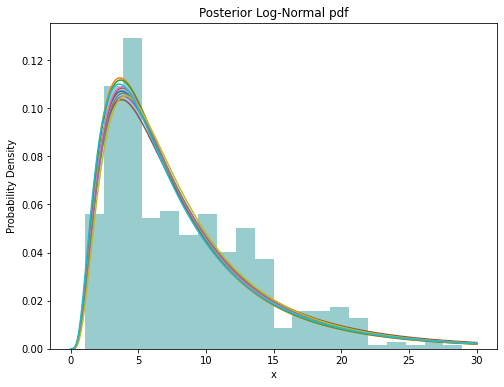

In [102]:
# generate 10 samples from the posterior
num_samples = 10
samples_3 = []
for i in range(num_samples):
  x = np.random.choice(posterior_samples_3['x'])
  sigma_2 = np.random.choice(posterior_samples_3['sigma_2'])
  samples_3.append((x, sigma_2))

# plot normal distributions corresponding to the samples
plt.figure(figsize=(8, 6))
plt.hist(data_set, bins=20, density=True, color='teal', alpha=0.4)
plot_x = np.linspace(0, 30, 200)
for i in range(num_samples):
    plot_y = sts.lognorm.pdf(plot_x, np.sqrt(samples_3[i][1]), 
                          scale=np.exp(samples_3[i][0]))
    plt.plot(plot_x, plot_y)
plt.title('Posterior Log-Normal pdf')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.show()